# Set-up

In [ ]:
%pip install POT

In [ ]:
!git clone https://github.com/josemiotto/pylevy.git
%cd pylevy
!python setup.py install

In [ ]:
from metrics import *
from sampling import *
from distributions import *

In [ ]:
from typing import *
import itertools
import numpy as np
import torch
import torch.nn.functional as F

from scipy.stats import gaussian_kde

from time import perf_counter
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from collections import defaultdict

from matplotlib import pyplot as plt

In [215]:
OPTIM_RATE = 0.574

# Mode distance

## Implementation

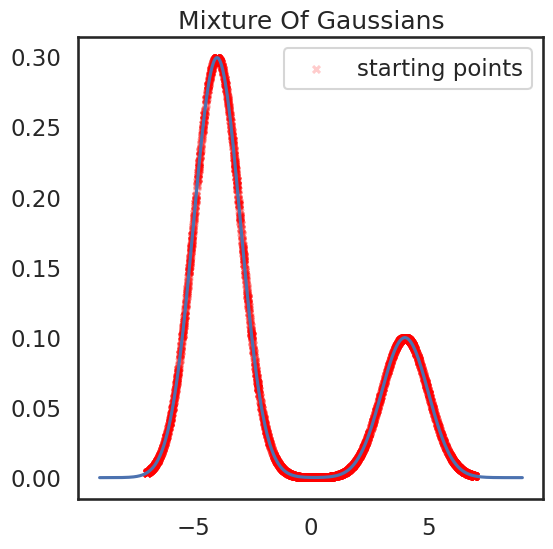

In [294]:
dim = 1
N_CHAINS = 5_000
N_SAMPLES = 600
BURN_IN = 0
sigma = 1
threshold = 0.01

step_size = 1.5
steps = np.arange(0, N_SAMPLES, 20)

a = 8
x_max = a//2 + 3*sigma
x_min = -x_max
locs = torch.tensor([[-a//2], [a//2]]).float()
covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
weights = torch.tensor([0.75, 0.25]).float()
mog = MoG(locs, covs, weights)
reference = mog.sample(torch.tensor([N_CHAINS]))
ref_kde = gaussian_kde(reference.squeeze())
start_mog = torch.rand((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min

distr = BernoulliStep(1, 4, 0.1)
plt.figure(figsize=(6,6))

start_mog = torch.rand((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min
mog.display_1d(start_mog, "starting points", 1000)

chains = {}
results = {}

In [295]:
chains["ULA"] = langevin(start_mog, mog, N_SAMPLES, 1.5, BURN_IN)[0].squeeze().clamp(x_min, x_max)
chains["MALA"] = langevin(start_mog, mog, N_SAMPLES, 1.75, BURN_IN, mh=True)[0].squeeze().clamp(x_min, x_max)

chains["RSULA"] = langevin(start_mog, mog, N_SAMPLES, 1.5, BURN_IN, step_distr=distr)[0].squeeze().clamp(x_min, x_max)
chains["RSMALA"] = langevin(start_mog, mog, N_SAMPLES, 1.75, BURN_IN, mh=True, step_distr=distr)[0].squeeze().clamp(x_min, x_max)

chains["FLA"] = stable_langevin(start_mog, mog, N_SAMPLES, 1.5, BURN_IN, alpha=1.8)[0].squeeze().clamp(x_min, x_max)
chains["FMALA"] = stable_langevin(start_mog, mog, N_SAMPLES, 1.75, BURN_IN, mh=True, alpha=1.8)[0].squeeze().clamp(x_min, x_max)

In [296]:
for name in chains:
    results[name] = np.empty(len(steps))
    for res_num, step in enumerate(steps):
        results[name][res_num] = TV_1d(chains[name][step], None, ref_kde)

## Results

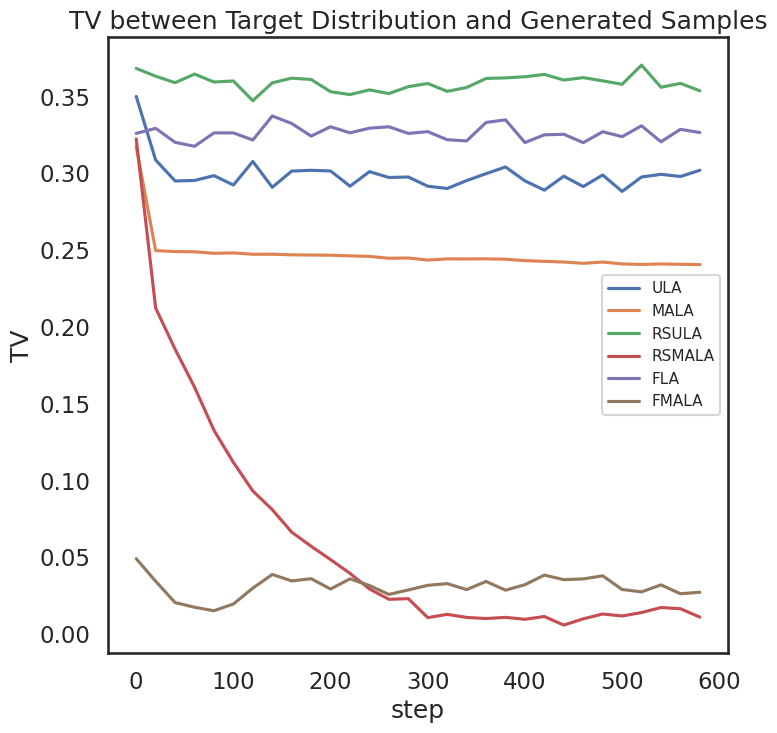

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

for name in chains:
    plt.plot(steps, results[name], label=name)
# plt.axhline(y=threshold, color="r", linestyle = "--", label="threshold")
ax.set(xlabel="step", ylabel="TV", title="TV between Target Distribution and Generated Samples")
plt.legend(prop={'size': 11});
plt.savefig("tv.pdf")

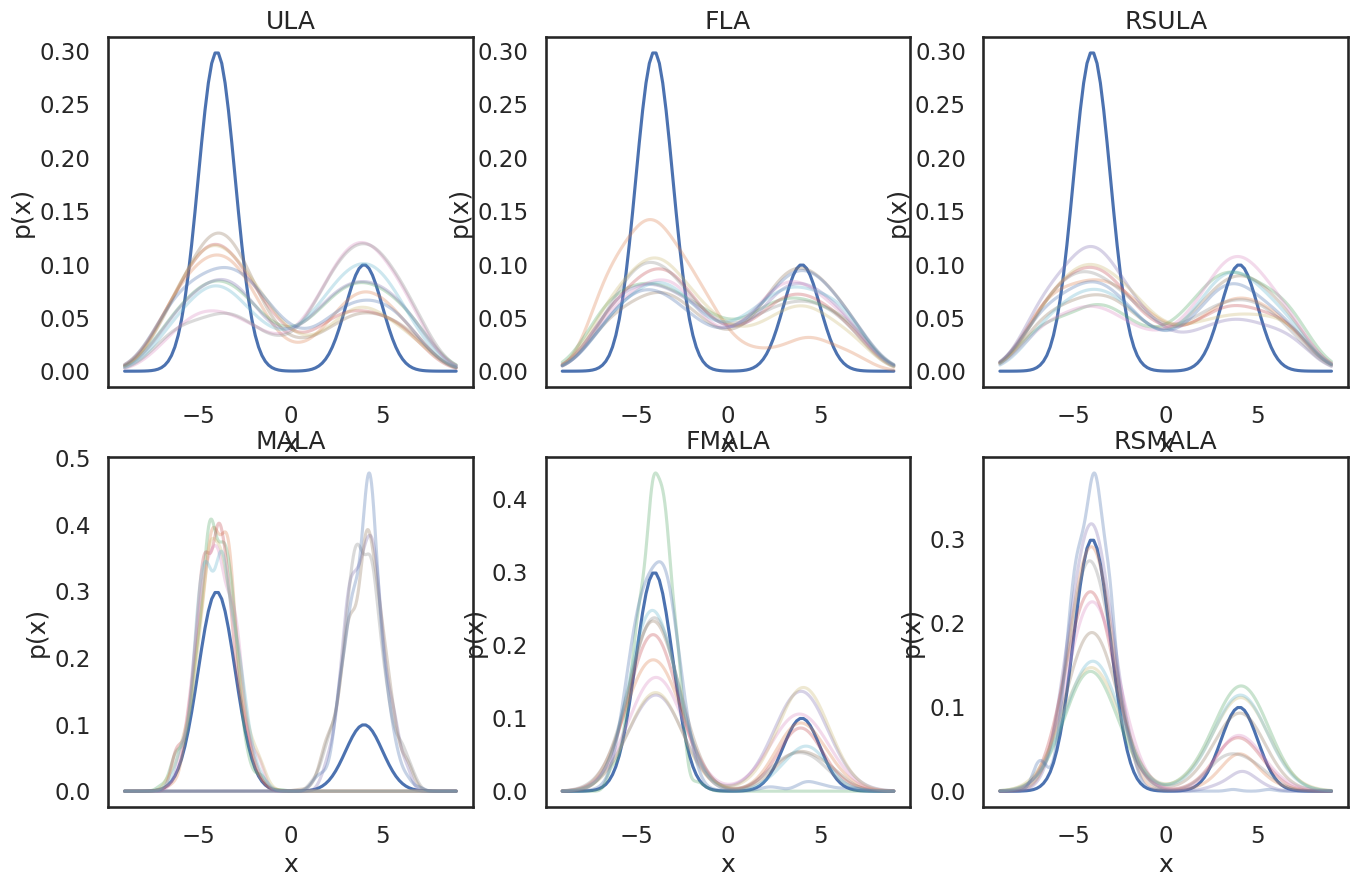

In [297]:
names = np.asarray(
    [["ULA", "FLA", "RSULA"],
    ["MALA", "FMALA", "RSMALA"]]
).flatten()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
axs = axs.flatten()

for name, ax in zip(names, axs):
    chain_kdes = [gaussian_kde(chains[name][:,i]) for i in range(10)]
    mog.display_1d(ax=ax)
    plot_kdes(chain_kdes, locs, covs, name, ax=ax)
    ax.set(xlabel="x", ylabel="p(x)")

plt.savefig("kdes.pdf")

# Convergence time depending on distance





### Implementation

In [ ]:
dim = 1
num_gaussians = 2
N_CHAINS = 10_000
N_SAMPLES = 25_000
BURN_IN = 100
sigma = 1
threshold = 0.01

step_size = 2

conv_step_size = 50
a_list = np.arange(6, 17, 0.5)
steps = np.arange(0, N_SAMPLES, conv_step_size)
const_results = np.ones((a_list.shape[0], steps.shape[0])) * np.inf
bern_results  = np.ones((a_list.shape[0], steps.shape[0])) * np.inf
distr = BernoulliStep(1, 4, 0.1)

In [ ]:
for i, a in enumerate(tqdm(a_list)):
    x_max = a//2 + 3*sigma
    x_min = -x_max
    locs = torch.tensor([[-a//2], [a//2]]).float()
    covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
    weights = torch.tensor([0.8, 0.2]).float()
    mog = MoG(locs, covs, weights)
    reference = mog.sample(torch.tensor([10000]))
    ref_kde = gaussian_kde(reference.squeeze())
    start_mog = torch.rand((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min
    
    const_chains, acc_rate = langevin(start_mog, mog, N_SAMPLES, step_size, BURN_IN, mh=True)
    const_chains = const_chains.squeeze()
    print(acc_rate.mean())
    chains, acc_rate = langevin(start_mog, mog, N_SAMPLES, step_size, BURN_IN, mh=True, step_distr=distr) 
    chains = chains.squeeze()
    print(acc_rate.mean())
    print("-----")

    for res_num, step in enumerate(steps):
        const_results[i, res_num] = TV_1d(const_chains[step], None, ref_kde)
        bern_results [i, res_num] = TV_1d(chains[step], None, ref_kde)

  0%|          | 0/22 [00:00<?, ?it/s]

0.5047275920041758
0.465574567196381
-----
0.5008756367899292
0.46165425378143493
-----
0.5009516614082441
0.4616198806842761
-----
0.5009125967627734
0.461650562246344
-----
0.5001622586004176
0.4605912985789835
-----
0.5000323132762862
0.4600756717143367
-----
0.5000188255621426
0.4601569603568879
-----
0.5000823877640624
0.46009880604732095
-----
0.5000362633798846
0.4596557313707931
-----
0.5000497459371884
0.45932925875210645
-----
0.500044422499576
0.45935241805676796
-----
0.4999452436192712
0.4593601244169088
-----
0.5000647708506727
0.45911966161348333
-----
0.49999025345145176
0.45885955231996317
-----
0.49996795978860475
0.45890142302014936
-----
0.4999987858459724
0.45887077118775144
-----
0.49994681058979745
0.45867013941949875
-----
0.5000444026906692
0.45842822900310676
-----
0.5000281439180397
0.4584569900160405
-----
0.4999900147437456
0.45845993044957595
-----
0.5000127359216486
0.4583236368185845
-----
0.500104328026226
0.458253567211367
-----


In [ ]:
dim = 1
N_CHAINS = 5_000
N_SAMPLES = 10_000
BURN_IN = 100
sigma = 1
threshold = 0.01

step_size = 2

conv_step_size = 50
fmala_a_list = np.arange(8, 9, 1)
steps = np.arange(0, N_SAMPLES, conv_step_size)
fmala_results  = np.ones((fmala_a_list.shape[0], steps.shape[0])) * np.inf

In [ ]:
for i, a in enumerate(tqdm(fmala_a_list)):
    x_max = a//2 + 3*sigma
    x_min = -x_max
    locs = torch.tensor([[-a//2], [a//2]]).float()
    covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
    weights = torch.tensor([0.8, 0.2]).float()
    mog = MoG(locs, covs, weights)
    reference = mog.sample(torch.tensor([N_CHAINS]))
    ref_kde = gaussian_kde(reference.squeeze())
    start_mog = torch.rand((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min
    
    FMALA_chains, acc_rate = stable_langevin(start_mog, mog, N_SAMPLES, step_size, BURN_IN, mh=True, alpha=1.8)
    FMALA_chains = FMALA_chains.squeeze()
    print(acc_rate.mean())

    for res_num, step in enumerate(steps):
        fmala_results[i, res_num] = TV_1d(FMALA_chains[step], None, ref_kde)
    print(np.argmax(fmala_results[i] <= threshold) * conv_step_size)
    print("-----")

  0%|          | 0/1 [00:00<?, ?it/s]

0.48444059377259546
1450
-----


In [ ]:
fmala_results

array([[0.05348785, 0.02942221, 0.01316299, 0.01663527, 0.01394145,
        0.02018554, 0.01408851, 0.01629321, 0.01778134, 0.02217584,
        0.01067305, 0.01519536, 0.02767892, 0.01876723, 0.01146827,
        0.01369636, 0.01388132, 0.01495475, 0.01183464, 0.01406938,
        0.01233029, 0.01701821, 0.02128017, 0.01526543, 0.01369612,
        0.0144986 , 0.01059622, 0.01696977, 0.01021534, 0.00900765,
        0.012126  , 0.0172901 , 0.01220139, 0.0146678 , 0.02026677,
        0.01491789, 0.00774247, 0.01753891, 0.01355635, 0.01206922,
        0.00711715, 0.01411808, 0.01963096, 0.0108924 , 0.01720085,
        0.01861499, 0.01320571, 0.01041513, 0.00995919, 0.01792311,
        0.01329114, 0.01508393, 0.01090514, 0.0128227 , 0.01339642,
        0.01080227, 0.0126215 , 0.01196886, 0.01927368, 0.01543668,
        0.00819149, 0.0109684 , 0.01302092, 0.0099837 , 0.00767153,
        0.01561425, 0.01597025, 0.01166703, 0.00779886, 0.01256611,
        0.01851326, 0.01633152, 0.0101894 , 0.01

In [ ]:
dim = 1
N_CHAINS = 5_000
N_SAMPLES = 10_000
BURN_IN = 100
sigma = 1
threshold = 0.01

step_size = 2

conv_step_size = 50
fmala_a_list = np.arange(6, 17, 1)
steps = np.arange(0, N_SAMPLES, conv_step_size)
fmala_results  = np.ones((fmala_a_list.shape[0], steps.shape[0])) * np.inf

In [ ]:
for i, a in enumerate(tqdm(fmala_a_list)):
    x_max = a//2 + 3*sigma
    x_min = -x_max
    locs = torch.tensor([[-a//2], [a//2]]).float()
    covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
    weights = torch.tensor([0.8, 0.2]).float()
    mog = MoG(locs, covs, weights)
    reference = mog.sample(torch.tensor([N_CHAINS]))
    ref_kde = gaussian_kde(reference.squeeze())
    start_mog = torch.rand((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min
    
    FMALA_chains, acc_rate = stable_langevin(start_mog, mog, N_SAMPLES, step_size, BURN_IN, mh=True, alpha=1.8)
    FMALA_chains = FMALA_chains.squeeze()
    print(acc_rate.mean())

    for res_num, step in enumerate(steps):
        fmala_results[i, res_num] = TV_1d(FMALA_chains[step], None, ref_kde)
    print(np.argmax(fmala_results[i] <= threshold) * conv_step_size)
    print("-----")

  0%|          | 0/11 [00:00<?, ?it/s]

0.5031619803799261
0
-----
0.4907382175591913
1350
-----
0.48453471259610487
750
-----
0.4813485739166194
200
-----
0.4800706533394238
950
-----
0.4791552472114563
1650
-----
0.4787159204571554
1000
-----
0.47853118793209
1650
-----
0.4783986334546958
1700
-----
0.47815912861045046
4500
-----
0.4782256037173885
2700
-----


In [ ]:
np.save("results/fmala_results.npy", fmala_results)

In [ ]:
const_results      = np.load("results/const_results.npy")
best_const_results = np.load("results/best_const_results.npy")
bern_results       = np.load("results/bern_results.npy")
fmala_results      = np.load("results/fmala_results.npy")

In [ ]:
def get_times(results_arr, theshold=threshold*1.5):
    # calculate first moment of crossing threshold
    crosses = np.cumsum(results_arr <= threshold, axis=1)
    times_arr = np.argmax(crosses >= 2, axis=1).astype(float) * conv_step_size
    # replace non-convergent chains to NaNs
    times_arr[crosses[:,-1]==0] = np.nan
    return times_arr

In [ ]:
const_times      = get_times(const_results)
best_const_times = get_times(best_const_results)
bern_times       = get_times(bern_results)
bern_times       = get_times(bern_results)
fmala_times      = get_times(fmala_results)

### Results

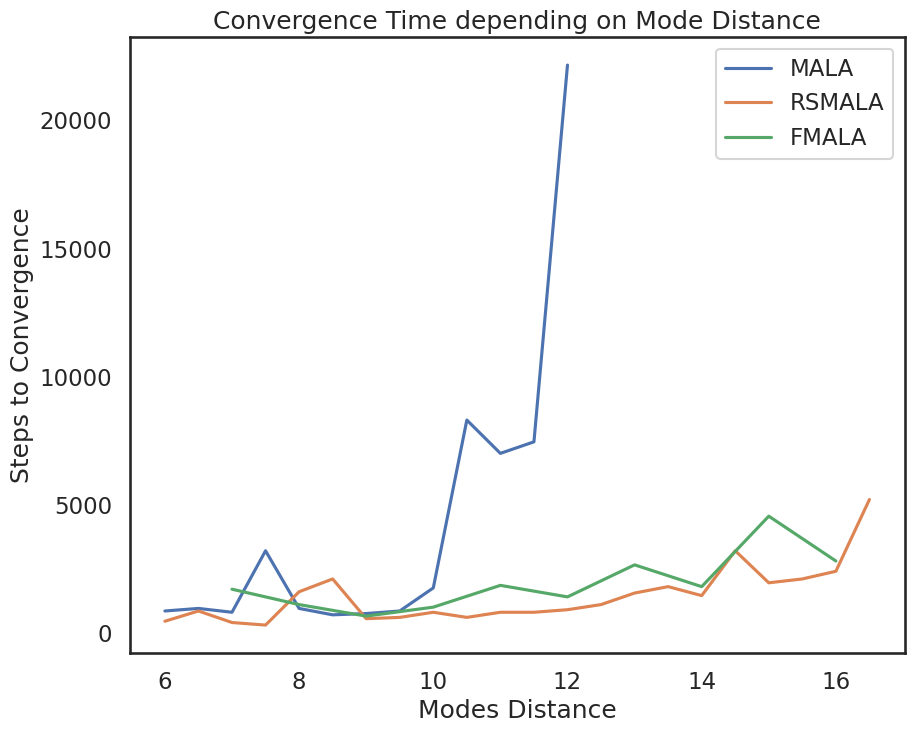

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
plt.plot(a_list, best_const_times, label="MALA")
plt.plot(a_list, bern_times, label="RSMALA")
plt.plot(fmala_a_list, fmala_times, label="FMALA")
plt.xlabel("Modes Distance")
plt.ylabel("Steps to Convergence")
plt.title("Convergence Time depending on Mode Distance")
plt.legend()
plt.savefig("convergence.pdf");

# Time Comparison

## Implementation

In [ ]:
dim_grid = np.logspace(0, 7, 8, base=2, dtype=int)

n_chains= 1000
n_samples = 1000
step_size = 0.5
burn_in = 0
distr = BernoulliStep(1, 4, 0.1)
time_results = defaultdict(list)

for dim in dim_grid:
    target = MNormal(torch.zeros(dim), torch.eye(dim))
    start = torch.rand((n_chains,dim)) * 2 - 1 # U[-1, 1]^dim 

    t_0 = perf_counter()
    langevin(start, target, n_samples, step_size, burn_in) # ULA
    time_results["ULA"].append(perf_counter() - t_0)

    t_0 = perf_counter()
    langevin(start, target, n_samples, step_size, burn_in, step_distr=distr) # RSULA
    time_results["RSULA"].append(perf_counter() - t_0)

    t_0 = perf_counter()
    stable_langevin(start, target, n_samples, step_size, burn_in) # FLA
    time_results["FLA"].append(perf_counter() - t_0)

    t_0 = perf_counter()
    langevin(start, target, n_samples, step_size, burn_in, mh=True) # MALA
    time_results["MALA"].append(perf_counter() - t_0)

    t_0 = perf_counter()
    langevin(start, target, n_samples, step_size, burn_in, step_distr=distr, mh=True) # RSMALA
    time_results["RSMALA"].append(perf_counter() - t_0)

    t_0 = perf_counter()
    stable_langevin(start, target, n_samples, step_size, burn_in, mh=True) # FMALA
    time_results["FMALA"].append(perf_counter() - t_0)

In [ ]:
np.save("time_results.npy", time_results)

In [ ]:
colors = {
    "ULA"    : "C0",
    "MALA"   : "C0",
    "RSULA"  : "C1",
    "RSMALA" : "C1",
    "FLA"    : "C2",
    "FMALA"  : "C2",
}

## Results

In [ ]:
np.load("time_results.npy", time_results)

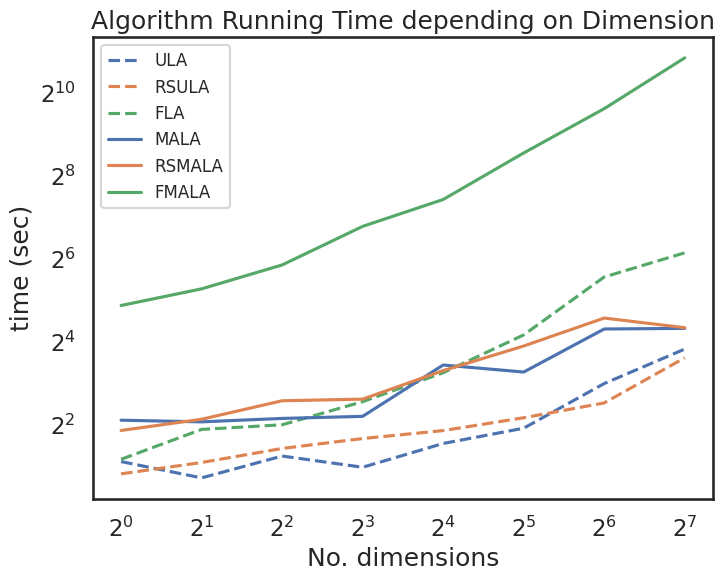

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
for name, times in time_results.items():
    if name.endswith("MALA"):
        plt.semilogx(dim_grid, times, label=name, c=colors[name])
    else:
        plt.semilogx(dim_grid, times, label=name, c=colors[name], linestyle="--")
ax.set_yscale("log", base=2)
ax.set_xscale("log", base=2)
plt.legend(prop={'size': 12});
ax.set(xlabel="dimension", ylabel="time (sec)", title="Algorithm Running Time depending on Dimension")
plt.savefig("time.pdf")

# Multidimensional case

## Implementation

In [281]:
def update_results(chains, locs, sigma, reference, results, name, n_chains=20):
    if n_chains is None:
        n_chains = chains.shape[1]
    n_modes = get_modes_coverage(chains, locs, sigma).mean()
    ess = calc_ess(chains)
    tvs = [sliced_TV(chains[:,i], reference) for i in range(n_chains)]
    w2 = [calc_emd(chains[:,i], reference) for i in range(n_chains)]

    results["n_modes"][name].append(n_modes)
    results["ess"][name].append(round(ess, 3))
    results["tv"][name].append(round(np.mean(tvs), 3))
    results["w2"][name].append(round(np.mean(w2), 3))
    return n_modes, round(ess, 3), round(np.mean(tvs), 3), round(np.mean(w2), 2)

In [288]:
num_gaussians = 20
N_CHAINS = 100
N_SAMPLES = 1000
BURN_IN = 100
sigma = 1
x_max, x_min = 4, -4

dim_grid = np.linspace(2, 20, 10, dtype=int)
distr = BernoulliStep(1, 4, 0.1)
# step_size_grid = np.linspace(1, 3, 11)
delta = 0.1
step_sizes = {"MALA": 2, "RSMALA" : 2, "FMALA" : 2}

In [ ]:
results = {
    "n_modes" : defaultdict(list),
    "ess" : defaultdict(list),
    "tv" : defaultdict(list),
    "w2" : defaultdict(list),
}

for i, dim in enumerate(tqdm(dim_grid)):
    locs = torch.rand(num_gaussians, dim) * (x_max - x_min) + x_min
    # locs = locs + torch.randn_like(locs) / np.sqrt(2*dim)
    covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
    weights = torch.rand(locs.shape[0])
    weights /= weights.sum()
    mog = MoG(locs, covs, weights)
    start = torch.randn((N_CHAINS, mog.dim)) * (x_max - x_min) + x_min
    reference = mog.sample(torch.tensor([N_CHAINS]))

    print("---")
    for _ in range(15): # MALA
        chains, acc_rate = langevin(start, mog, N_SAMPLES, step_sizes["MALA"], burn_in, mh=True)
        acc_rate = acc_rate.mean()
        print(acc_rate)
        if acc_rate >= OPTIM_RATE*1.15:
            step_sizes["MALA"] += delta
        elif acc_rate < OPTIM_RATE/1.15 and step_sizes["MALA"] > delta:
            step_sizes["MALA"] -= delta
        else:
            update_results(chains, locs, sigma, reference, results, "MALA")
            delta *= 2
            break
    delta /= 2
    print("---")
    for _ in range(15): # RSMALA
        chains, acc_rate = langevin(start, mog, N_SAMPLES, step_sizes["RSMALA"], burn_in, step_distr=distr, mh=True)
        acc_rate = acc_rate.mean()
        print(acc_rate)
        if acc_rate >= OPTIM_RATE*1.15:
            step_sizes["RSMALA"] += delta
        elif acc_rate < OPTIM_RATE/1.15 and step_sizes["RSMALA"] > delta:
            step_sizes["RSMALA"] -= delta
        else:
            update_results(chains, locs, sigma, reference, results, "RSMALA")
            delta *= 2
            break
    delta /= 2
    print("---")
    for _ in range(15): # FMALA
        chains, acc_rate = stable_langevin(start, mog, N_SAMPLES, step_sizes["FMALA"], burn_in, mh=True)
        acc_rate = acc_rate.mean()
        print(acc_rate)
        if acc_rate >= OPTIM_RATE*1.15:
            step_sizes["FMALA"] += delta
        elif acc_rate < OPTIM_RATE/1.15 and step_sizes["FMALA"] > delta:
            step_sizes["FMALA"] -= delta
        else:
            update_results(chains, locs, sigma, reference, results, "FMALA")
            delta *= 2
            break
    delta /= 2
    print(dict(results))

## Results

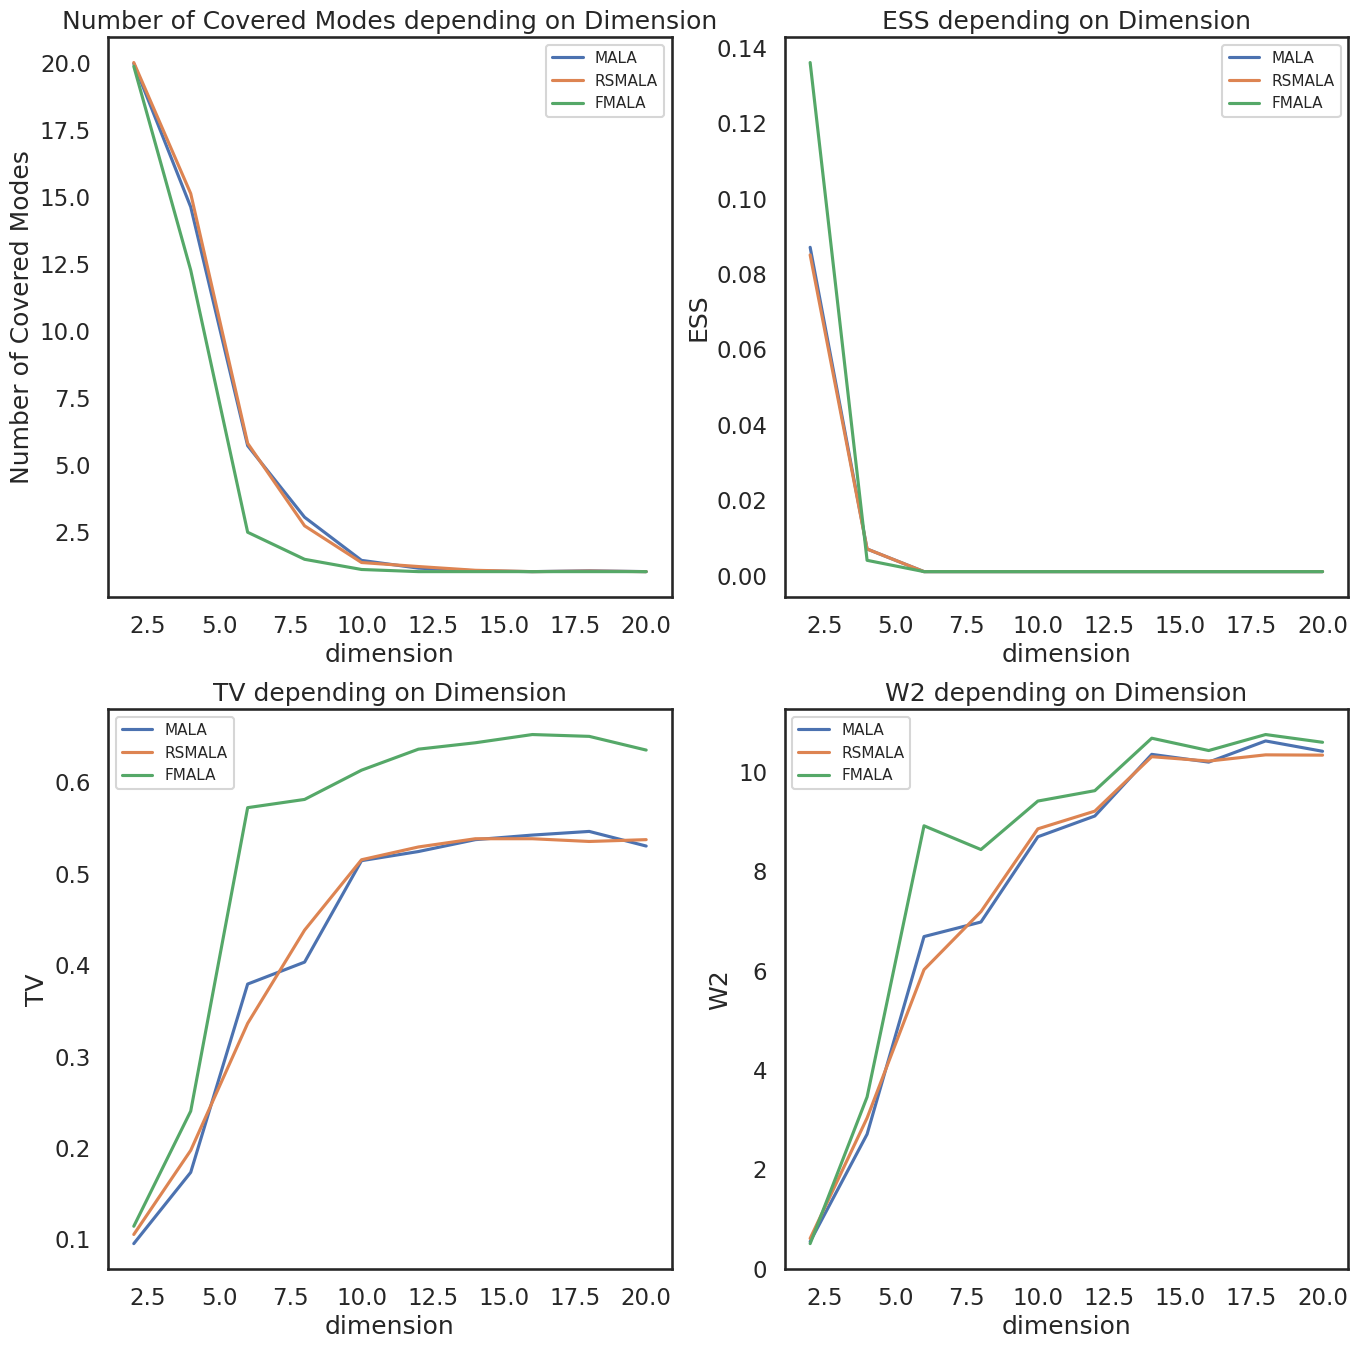

In [293]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
metric_names = ["n_modes", "ess", "tv", "w2"]
alg_names = ["MALA", "RSMALA", "FMALA"]

for metric_name, ax in zip(metric_names, ax.flatten()):
    for alg_name in alg_names:
        ax.plot(dim_grid, results[metric_name][alg_name], label=alg_name)
    if metric_name == "n_modes":
        ylabel = "Number of Covered Modes"
    else:
        ylabel = metric_name.upper()
    ax.set(xlabel="dimension", ylabel=ylabel, title=f"{ylabel} depending on Dimension")
    ax.legend(prop={'size': 11});
plt.savefig("multidimensional.pdf")